## NLP Final - Notebook #2 (Topic Modeling & Sentiment Analysis)
Author: Natalie Kim

Quarter: Winter 2025

In [1]:
import pandas as pd
df_final = pd.read_parquet('final_data_clean.parquet')

In [2]:
df_final.head(5)

,url,date,title_clean,title_clean_lower,text_clean_ner,text_clean_topic
0,http://www.dataweek.co.za/21690r,2024-04-05,Flash for AI 28 March 2024 EBV Electrolink Dat...,flash for ai 28 march 2024 ebv electrolink dat...,Flash for AI 28 March 2024 EBV Electrolink Dat...,flash for ai 28 march 2024 ebv electrolink dat...
1,http://www.mysmartrend.com/news-briefs/technic...,2020-04-17,Cr Bard Inc Has Returned 48.9% Since SmarTrend...,cr bard inc has returned 48.9% since smartrend...,Cr Bard Inc Has Returned 48.9% Since Recommend...,cr bard inc has returned 48.9% since recommend...
2,https://abcnews.go.com/Entertainment/video/ai-...,2024-04-06,Video AI used for hiring and firing focus of b...,video ai used for hiring and firing focus of b...,Video AI used for hiring and firing focus of b...,video ai used for hiring and firing focus of b...
3,https://boingboing.net/2020/08/14/cory-doctoro...,2020-08-14,Cory Doctorow experiments with AI writing part...,cory doctorow experiments with ai writing part...,Cory Doctorow experiments with AI writing part...,cory doctorow experiments with ai writing part...
4,https://cio.economictimes.indiatimes.com/news/...,2023-05-31,Artificial Intelligence Top AI CEOs experts ra...,artificial intelligence top ai ceos experts ra...,"Artificial Intelligence: Top AI CEOs, experts ...",artificial intelligence top ai ce os experts r...


In [3]:
# get subset of data (10%)
df_sub = df_final.sample(frac=0.1, random_state=2)
df_sub.shape

(19889, 6)

In [4]:
import sys
print(sys.version)

3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]


In [5]:
import time
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [6]:
import multiprocessing as mp
num_processors = mp.cpu_count()
print(f"Number of processors: {num_processors}")

workers = num_processors-1
print(f'Using {workers} workers')

Number of processors: 8
Using 7 workers


In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
import os
import re
import string
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from bertopic import BERTopic
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xnxk040/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# combine text and titles
df_sub['title_text'] = df_sub['title_clean_lower'] + ' ' + df_sub['text_clean_topic']
df_sub.head()

,url,date,title_clean,title_clean_lower,text_clean_ner,text_clean_topic,title_text
97226,https://www.13abc.com/prnewswire/2021/11/22/ca...,2021-11-22,Cardiologs AI Receives 510k Clearance for Pedi...,cardiologs ai receives 510k clearance for pedi...,Cardiologs' AI Receives 510k Clearance for Ped...,cardiologs ai receives 510 k clearance for ped...,cardiologs ai receives 510k clearance for pedi...
182739,https://www.hindustantimes.com/education/iit-m...,2020-01-28,IIT Madras offers data science courses at affo...,iit madras offers data science courses at affo...,IIT Madras offers data science courses at affo...,iit madras offers data science courses at affo...,iit madras offers data science courses at affo...
122864,https://www.hawaiinewsnow.com/prnewswire/2023/...,2023-11-29,Leading AI decisioning platform Rich Data Co s...,leading ai decisioning platform rich data co s...,Leading AI decisioning platform Rich Data Co s...,leading ai decisioning platform rich data co s...,leading ai decisioning platform rich data co s...
165020,https://citylife.capetown/my/uncategorized/int...,2023-12-23,Intel AI Chip,intel ai chip,"Intel AI Chip . AI ByGabriel Botha 14, 2023 In...",intel ai chip ai botha 14 2023 intel has made ...,intel ai chip intel ai chip ai botha 14 2023 i...
32468,https://www.shacknews.com/article/135358/slack...,2023-05-04,Slack GPT is the companys new AI chatbot Shack...,slack gpt is the companys new ai chatbot shack...,Slack GPT is the company's new AI chatbot Shac...,slack gpt is the company new ai chatbot shackn...,slack gpt is the companys new ai chatbot shack...


In [36]:
# additional preprocessing
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

additional_stopwords = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
                        "und", "die", "das", "von", "zu", "mit", "auf", "für", "ist", "im", "den", "der", "nicht", "ein", "eine", "als", "auch", 
                        "es", "an", "werden", "aus", "nach", "bei", "hat", "dass", "sich", "am", "noch", "wird", "wenn", "war", "sind", "oder", 
                        "aber", "zum", "so", "jetzt",'ke','ho', 'ki','said', 'di', 'ia', 'il','le', 'ka', 'te','2019','2020','2021','2022',
                        '2023','2024','nachrichten', 'ber', 'bersicht','fa', 'na', 'news', 'jpeg']

stop_words.update(additional_stopwords)

### BERTopic

In [37]:
# remove any leftover special characters
df_sub['bert_title_text'] = df_sub['title_text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

# remove stopwords
df_sub['bert_title_text'] = df_sub['bert_title_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

bert_text_list = df_sub['bert_title_text'].tolist()

In [38]:
%%time
bert_topic_model = BERTopic(language="english", min_topic_size=75, n_gram_range=(1,3), calculate_probabilities=True, verbose=True)
topics, probs = bert_topic_model.fit_transform(bert_text_list)

2025-03-09 11:22:40,604 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

2025-03-09 11:25:39,756 - BERTopic - Embedding - Completed ✓
2025-03-09 11:25:39,757 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 11:25:45,199 - BERTopic - Dimensionality - Completed ✓
2025-03-09 11:25:45,204 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

CPU times: user 2min 25s, sys: 18.2 s, total: 2min 43s
Wall time: 4min 9s


In [39]:
freq = bert_topic_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(5)

Topics found: 41


,Topic,Count,Name,Representation,Representative_Docs
0,-1,8092,-1_ai_new_data_technology,"[ai, new, data, technology, us, media, intelli...",[rishis highlevel summit moment pm takes centr...
1,0,1357,0_health_ai_clinical_medical,"[health, ai, clinical, medical, care, healthca...",[ferrum health raises 6 million bring artifici...
2,1,916,1_rawpixel_px 300_px_300,"[rawpixel, px 300, px, 300, rawpixel ltd, imag...",[autumn landscape outdoors nature ai free phot...
3,2,854,2_ai_data_customer_business,"[ai, data, customer, business, cloud, platform...",[natwest ibm collaborate generative ai initiat...
4,3,732,3_market_growth_analysis_global,"[market, growth, analysis, global, intelligenc...",[machine learning market size 20222029 worth u...


In [40]:
bert_topic_model.visualize_topics()

In [41]:
bert_topic_model.reduce_topics(bert_text_list, nr_topics=35)
bert_topic_model.visualize_topics()

2025-03-09 11:28:33,590 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 11:29:22,987 - BERTopic - Topic reduction - Reduced number of topics from 41 to 35


In [42]:
bert_topic_model.merge_topics(bert_text_list, [[10, 25], [2,14], [8, 31, 21, 9], [23, 28]])
bert_topic_model.visualize_topics()

In [48]:
bert_topic_model.merge_topics(bert_text_list, [[3, 4]])

In [49]:
# Get topic info as a DataFrame
topic_info = bert_topic_model.get_topic_info()

# Exclude the outlier topic (-1)
valid_topics = topic_info[topic_info.Topic != -1].Topic.tolist()

# Extract top words for each topic
topics = []
for t in valid_topics:
    # bert_topic_model.get_topic() returns a list of tuples (word, weight)
    topic_words = [word for word, _ in bert_topic_model.get_topic(t)]
    topics.append(topic_words)

print("Extracted Topics:")
for idx, topic in zip(valid_topics, topics):
    print(f"Topic {idx}: {topic}")

Extracted Topics:
Topic 0: ['market', 'price', 'ai', 'share', 'share price', 'stock', 'growth', 'intelligence', 'global', 'artificial']
Topic 1: ['health', 'ai', 'clinical', 'medical', 'care', 'healthcare', 'patient', 'patients', 'cancer', 'gray']
Topic 2: ['rawpixel', 'px 300', 'px', '300', 'ai', 'image', 'photo', 'ai generated image', 'rawpixel ltd', 'generated image']
Topic 3: ['ai', 'data', 'customer', 'business', 'generative', 'generative ai', 'gray', 'platform', 'new', 'cloud']
Topic 4: ['gpt', 'chat', 'chat gpt', 'ai', 'microsoft', 'open ai', 'open', 'new', 'google', 'bing']
Topic 5: ['nvidia', 'ai', 'edge', 'us', 'new', 'vision', 'amd', 'data', 'performance', 'company']
Topic 6: ['india', 'ai', 'global', 'uae', 'business', 'dh', 'world', 'us', 'new', 'indian']
Topic 7: ['ai', 'intelligence', 'artificial', 'artificial intelligence', 'biden', 'new', 'technology', 'could', 'us', 'like']
Topic 8: ['sports', 'republic', 'ai', 'nfl', 'home', 'first', 'new', 'game', 'philanthropic', '

In [50]:
%%time

# saving model
path_bert = '/Users/xnxk040/Library/CloudStorage/OneDrive-TheUniversityofChicago/winter 2025/nlp/final'

if not os.path.isdir(path_bert): os.mkdir(path_bert)

bert_topic_model.save(path_bert +'/bert_model_75_1-3_27topics')

# save topic information to csv file
topic_info = bert_topic_model.get_topic_info()

topic_info.to_csv("topic_info_75_1-3_27topics.csv", index=False)

2025-03-09 11:51:23,112 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


CPU times: user 25.7 s, sys: 2.65 s, total: 28.4 s
Wall time: 34.9 s


In [51]:
df_sub['topic'] = bert_topic_model.topics_
df_sub.head()

,url,date,title_clean,title_clean_lower,text_clean_ner,text_clean_topic,title_text,bert_title_text,topic
97226,https://www.13abc.com/prnewswire/2021/11/22/ca...,2021-11-22,Cardiologs AI Receives 510k Clearance for Pedi...,cardiologs ai receives 510k clearance for pedi...,Cardiologs' AI Receives 510k Clearance for Ped...,cardiologs ai receives 510 k clearance for ped...,cardiologs ai receives 510k clearance for pedi...,cardiologs ai receives 510k clearance pediatri...,1
182739,https://www.hindustantimes.com/education/iit-m...,2020-01-28,IIT Madras offers data science courses at affo...,iit madras offers data science courses at affo...,IIT Madras offers data science courses at affo...,iit madras offers data science courses at affo...,iit madras offers data science courses at affo...,iit madras offers data science courses afforda...,10
122864,https://www.hawaiinewsnow.com/prnewswire/2023/...,2023-11-29,Leading AI decisioning platform Rich Data Co s...,leading ai decisioning platform rich data co s...,Leading AI decisioning platform Rich Data Co s...,leading ai decisioning platform rich data co s...,leading ai decisioning platform rich data co s...,leading ai decisioning platform rich data co s...,-1
165020,https://citylife.capetown/my/uncategorized/int...,2023-12-23,Intel AI Chip,intel ai chip,"Intel AI Chip . AI ByGabriel Botha 14, 2023 In...",intel ai chip ai botha 14 2023 intel has made ...,intel ai chip intel ai chip ai botha 14 2023 i...,intel ai chip intel ai chip ai botha 14 intel ...,5
32468,https://www.shacknews.com/article/135358/slack...,2023-05-04,Slack GPT is the companys new AI chatbot Shack...,slack gpt is the companys new ai chatbot shack...,Slack GPT is the company's new AI chatbot Shac...,slack gpt is the company new ai chatbot shackn...,slack gpt is the companys new ai chatbot shack...,slack gpt companys new ai chatbot shacknews sl...,-1


In [52]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8092,-1_ai_new_data_technology,"[ai, new, data, technology, us, media, intelli...",[sap microsoft collaborate joint generative ai...
1,0,1966,0_market_price_ai_share,"[market, price, ai, share, share price, stock,...",[unlocking wealth ai blockchain solutions uncl...
2,1,1357,1_health_ai_clinical_medical,"[health, ai, clinical, medical, care, healthca...",[concertais terarecon adds cardio suite eureka...
3,2,1194,2_rawpixel_px 300_px_300,"[rawpixel, px 300, px, 300, ai, image, photo, ...",[room architecture furniture building ai free ...
4,3,1122,3_ai_data_customer_business,"[ai, data, customer, business, generative, gen...",[contextual ai google cloud partner bring gene...
5,4,717,4_gpt_chat_chat gpt_ai,"[gpt, chat, chat gpt, ai, microsoft, open ai, ...",[chatgpt memory explained use turn chat gpt me...
6,5,700,5_nvidia_ai_edge_us,"[nvidia, ai, edge, us, new, vision, amd, data,...",[supermicro expands ai solutions upcoming nvid...
7,6,516,6_india_ai_global_uae,"[india, ai, global, uae, business, dh, world, ...",[jameel clinic hosts first conference kingdom ...
8,7,479,7_ai_intelligence_artificial_artificial intell...,"[ai, intelligence, artificial, artificial inte...",[biden seeks move quickly ai safeguards execut...
9,8,477,8_sports_republic_ai_nfl,"[sports, republic, ai, nfl, home, first, new, ...",[sonix releases new generative ai summarizatio...


In [53]:
# select top candidates
df_sent = df_sub[df_sub['topic'].isin([0, 1, 2, 3, 12, 21, 22, 23, 24])]

### Topic Sentiment Analysis

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline

In [60]:
# initialize sentiment analysis pipeline (0 for GPU)
sentiment_pipe = pipeline("text-classification", 
                          model="siebert/sentiment-roberta-large-english", 
                          device = -1,
                          truncation=True
                          )

Device set to use cpu


In [ ]:
# # test model
# sample_text = "company's performance in AI has been outstanding and innovative"
# result = pipe(sample_text)
# print("Sample output:", result)

Sample output: [{'label': 'POSITIVE', 'score': 0.9988640546798706}]


In [ ]:
# converting sentiment output to numeric score
def get_sentiment_
    try:
        result = sentiment_pipe(text)[0]
        # Assign a positive score if label is POSITIVE, negative if NEGATIVE.
        score = result['score'] if result['label'] == "POSITIVE" else -result['score']
        return score
    except Exception as e:
        return 0.0

In [ ]:
%%time

# applying sentiment to each document
df_sent['sentiment_score'] = df_sent['text_clean_topic'].apply(get_sentiment_score)

In [62]:
# converting 'date' column
df_sent['date'] = pd.to_datetime(df_sent['date'])

In [63]:
# grouping sentiment score by month & average
sentiment_timeline = df_sent.groupby(pd.Grouper(key='date', freq='M'))['sentiment_score'].mean()

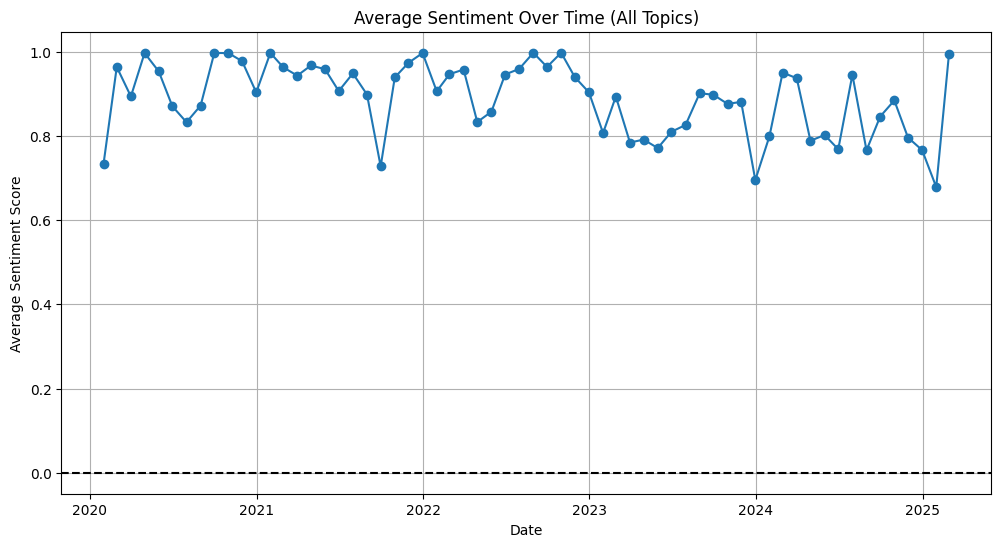

In [65]:
# plotting sentiment over time timeline
plt.figure(figsize=(12, 6))
plt.plot(sentiment_timeline.index, sentiment_timeline.values, marker='o')
plt.title("Average Sentiment Over Time (All Topics)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Group by topic and by month (or another frequency) to get the average sentiment score
grouped = df_sent.groupby(['topic', pd.Grouper(key='date', freq='M')])['sentiment_score'].mean().reset_index()

In [71]:
selected_topics = [0, 1, 2, 3, 12, 21, 22, 23, 24]

topic_names = {
    0: "Financial Markets & AI",
    1: "Healthcare & Medical AI",
    2: "AI-Driven Image Generation",
    3: "Generative AI in Business",
    12: "Cybersecurity & AI Defense",
    21: "Autonomous Vehicles & AI",
    22: "AI, Copyright & Media",
    23: "Banking & Fraud Analytics",
    24: "Legal Tech & AI in Law"
}

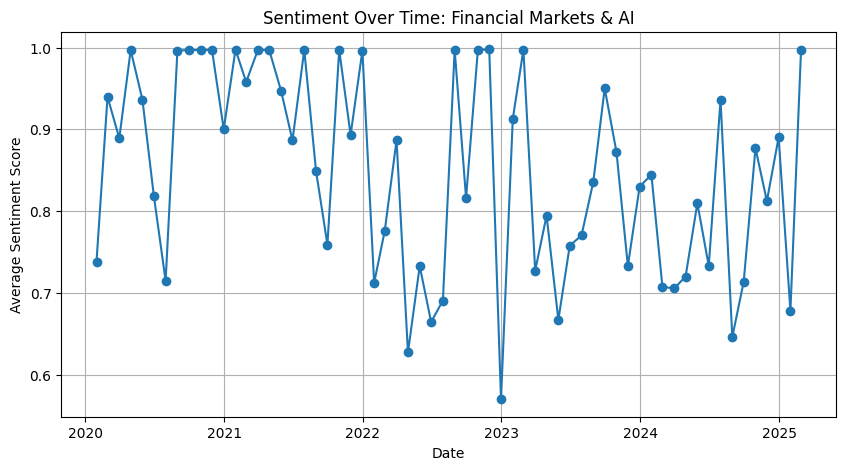

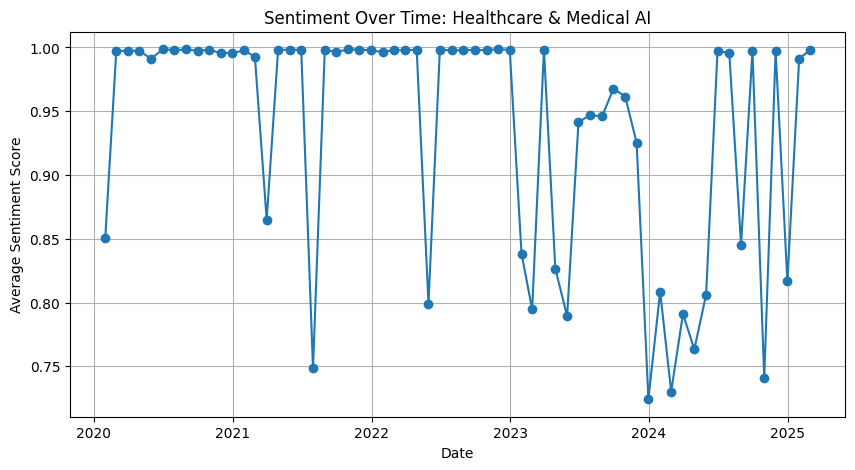

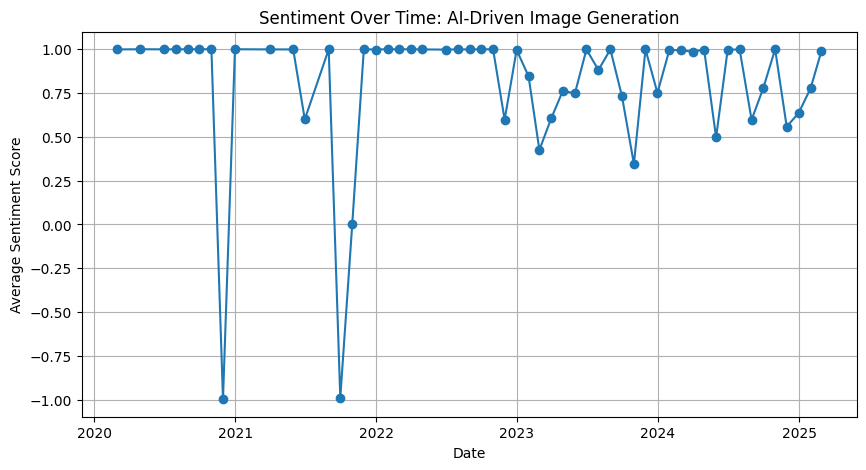

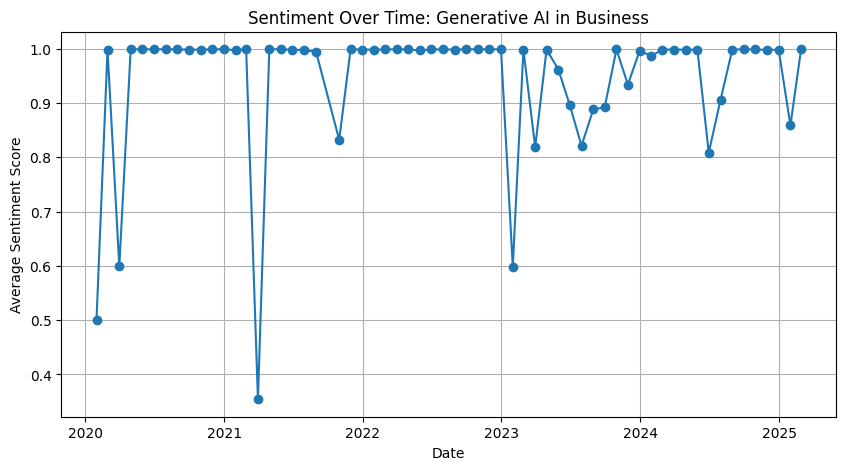

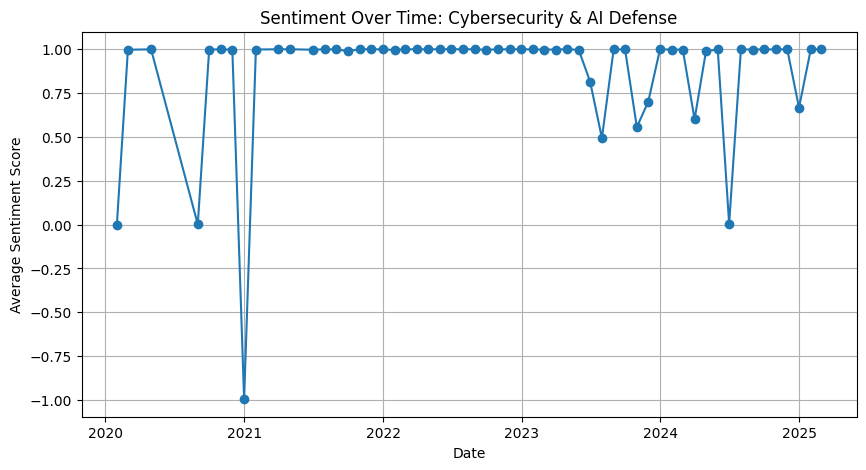

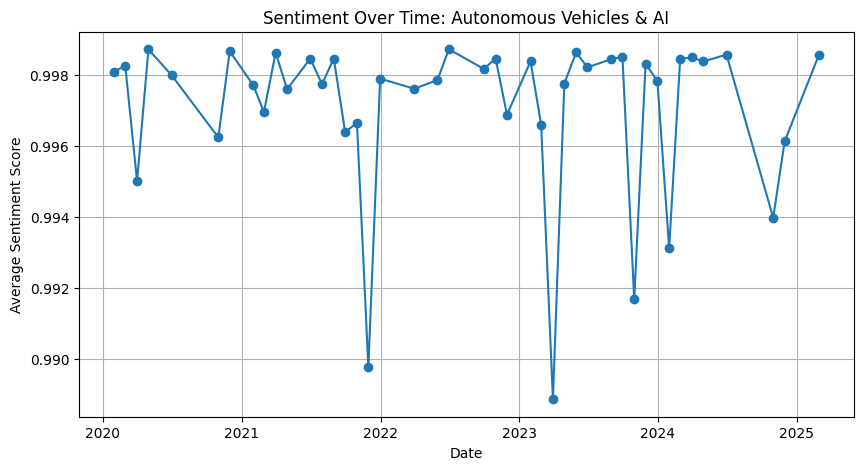

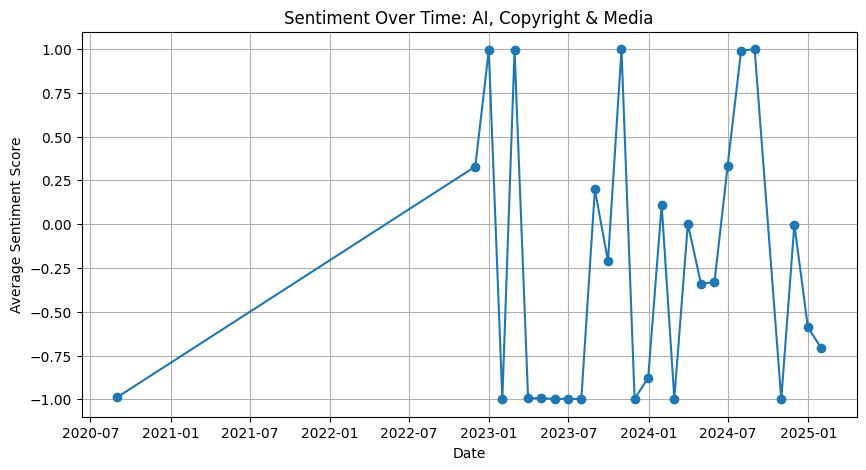

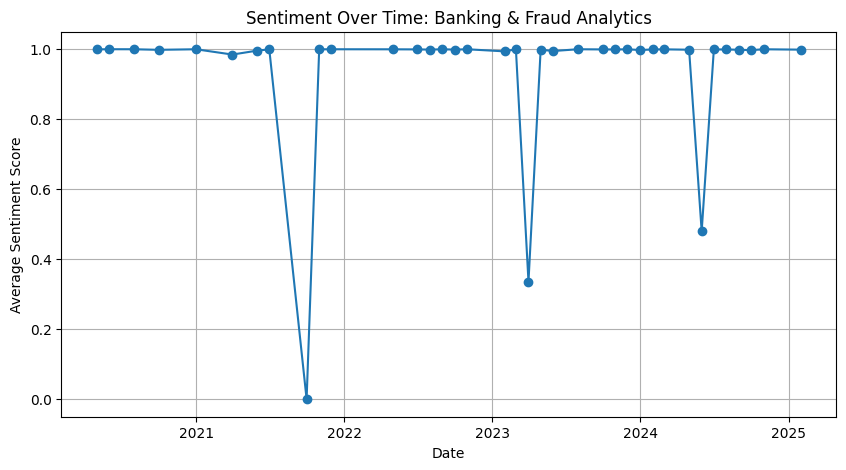

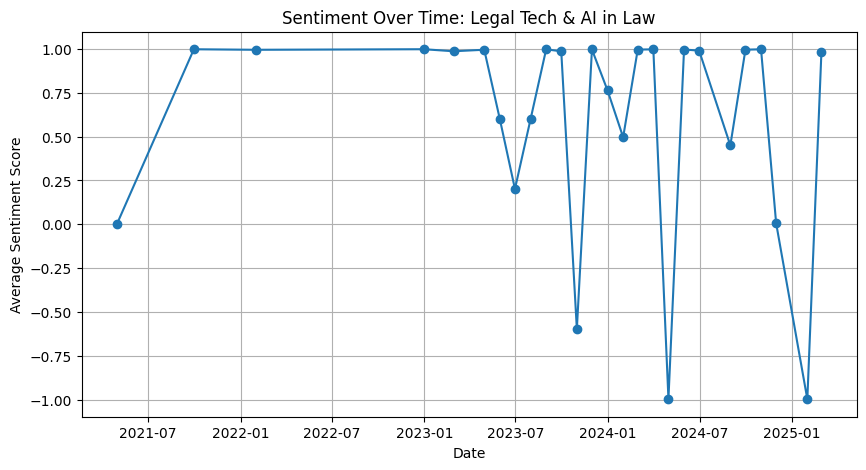

In [72]:
for topic in selected_topics:
    # Filter grouped data for the current topic:
    topic_data = grouped[grouped['topic'] == topic]
    
    # Create a new plot for each topic:
    plt.figure(figsize=(10, 5))
    plt.plot(topic_data['date'], topic_data['sentiment_score'], marker='o', linestyle='-')
    
    # Use the human-readable name if it exists; otherwise, fallback to "Topic X"
    label = topic_names.get(topic, f"Topic {topic}")
    plt.title(f"Sentiment Over Time: {label}")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True)
    plt.show()

In [73]:
df_sent.head()

,url,date,title_clean,title_clean_lower,text_clean_ner,text_clean_topic,title_text,bert_title_text,topic,sentiment_score
97226,https://www.13abc.com/prnewswire/2021/11/22/ca...,2021-11-22,Cardiologs AI Receives 510k Clearance for Pedi...,cardiologs ai receives 510k clearance for pedi...,Cardiologs' AI Receives 510k Clearance for Ped...,cardiologs ai receives 510 k clearance for ped...,cardiologs ai receives 510k clearance for pedi...,cardiologs ai receives 510k clearance pediatri...,1,0.998643
26350,https://www.stereogum.com/2237338/l-s-dunes-de...,2023-09-28,L S Dunes Defend Using Generative AI For Old W...,l s dunes defend using generative ai for old w...,"L.S. Dunes Defend Using Generative AI For ""Old...",l s dunes defend using generative ai for old w...,l s dunes defend using generative ai for old w...,l dunes defend using generative ai old wounds ...,2,0.991735
149886,https://www.rawpixel.com/image/12630503/caterp...,2024-02-21,Caterpillar insect animal plant AI Premium Pho...,caterpillar insect animal plant ai premium pho...,Caterpillar insect animal plant. AI Premium Ph...,caterpillar insect animal plant ai premium pho...,caterpillar insect animal plant ai premium pho...,caterpillar insect animal plant ai premium pho...,2,0.995960
188054,https://www.alaskasnewssource.com/prnewswire/2...,2023-03-21,Guidehouse Insights Estimates Smart City AI Re...,guidehouse insights estimates smart city ai re...,Guidehouse Insights Estimates Smart City AI Re...,guidehouse insights estimates smart city ai re...,guidehouse insights estimates smart city ai re...,guidehouse insights estimates smart city ai re...,0,0.998272
100712,https://www.slideshare.net/s2econsultinginc/gu...,2020-05-02,Guiding the Adoption of Artificial Intelligenc...,guiding the adoption of artificial intelligenc...,Guiding the Adoption of Artificial Intelligenc...,guiding the adoption of artificial intelligenc...,guiding the adoption of artificial intelligenc...,guiding adoption artificial intelligence busin...,3,0.998642


In [74]:
df_sent.to_csv("df_topcandidates_w_sent.csv", index=False)

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model as you did before (if not already loaded)
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

# Save the model and tokenizer to a directory
save_directory = "./my_sentiment_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./my_sentiment_model/tokenizer_config.json',
 './my_sentiment_model/special_tokens_map.json',
 './my_sentiment_model/vocab.json',
 './my_sentiment_model/merges.txt',
 './my_sentiment_model/added_tokens.json',
 './my_sentiment_model/tokenizer.json')

In [78]:
df_sent['sentiment_label'] = df_sent['sentiment_score'].apply(lambda x: "Positive" if x >= 0 else "Negative")

In [81]:
# getting sample
sample_df_sent = df_sent.sample(20, random_state = 42)
# print(sample_df_sent[['text_clean_topic', 'sentiment_label', 'sentiment_score']])

# Save the article from row 0 to a text file
with open("article_0.txt", "w", encoding="utf-8") as f:
    f.write(df_sub['text_clean_topic'].iloc[0])

#### BERTopic Model, topic size 50, ngram range 1,3

In [29]:
%%time
bert_topic_model2 = BERTopic(language="english", min_topic_size=50, n_gram_range=(1,3), calculate_probabilities=True, verbose=True)
topics2, probs2 = bert_topic_model2.fit_transform(bert_text_list)

2025-03-09 11:07:58,309 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

2025-03-09 11:10:45,593 - BERTopic - Embedding - Completed ✓
2025-03-09 11:10:45,594 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 11:10:50,239 - BERTopic - Dimensionality - Completed ✓
2025-03-09 11:10:50,240 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

CPU times: user 2min 14s, sys: 17.1 s, total: 2min 32s
Wall time: 3min 48s


In [30]:
topic2_info = bert_topic_model2.get_topic_info()

print(f"Topics found: {topic2_info.shape[0]}")
topic2_info.head(5)

Topics found: 62


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7261,-1_ai_new_news_data,"[ai, new, news, data, us, technology, media, i...",[navigating complex landscape ai governance ch...
1,0,1193,0_health_clinical_ai_care,"[health, clinical, ai, care, medical, healthca...",[concertais terarecon partners claripi integra...
2,1,913,1_rawpixel_jpeg_px 300_px,"[rawpixel, jpeg, px 300, px, 300, rawpixel ltd...",[city architecture cityscape outdoors ai free ...
3,2,862,2_ai_data_customer_business,"[ai, data, customer, business, cloud, generati...",[natwest ibm collaborate generative ai initiat...
4,3,723,3_market_growth_analysis_global,"[market, growth, analysis, global, intelligenc...",[artificial intelligence solutions market size...


In [31]:
bert_topic_model2.visualize_topics()

In [33]:
bert_topic_model2.reduce_topics(bert_text_list, nr_topics=40)
bert_topic_model2.visualize_topics()

2025-03-09 11:14:13,130 - BERTopic - Topic reduction - Reducing number of topics
2025-03-09 11:14:59,652 - BERTopic - Topic reduction - Reduced number of topics from 50 to 40


In [34]:
bert_topic_model2.merge_topics(bert_text_list, [[36,34,29], [33, -1], [30, 31]])

In [35]:
bert_topic_model2.visualize_topics()

In [ ]:
bert_topic_model2.merge_topics(bert_text_list, [[3,8], [1, 30], [25, 19], [22,9]])
bert_topic_model2.visualize_topics()

In [ ]:
# Get topic info as a DataFrame
topic2_info = bert_topic_model2.get_topic_info()

# Exclude the outlier topic (-1)
valid_topics2 = topic2_info[topic2_info.Topic != -1].Topic.tolist()

# Extract top words for each topic
topic2 = []
for t in valid_topics2:
    # bert_topic_model.get_topic() returns a list of tuples (word, weight)
    topic_words = [word for word, _ in bert_topic_model2.get_topic(t)]
    topic2.append(topic_words)

print("Extracted Topics:")
for idx, topic in zip(valid_topics2, topic2):
    print(f"Topic {idx}: {topic}")

Extracted Topics:
Topic 0: ['ai', 'market', 'news', 'data', 'new', 'intelligence', 'technology', 'artificial', 'artificial intelligence', 'us']
Topic 1: ['health', 'ai', 'medical', 'healthcare', 'care', 'clinical', 'patient', 'patients', 'cancer', 'data']
Topic 2: ['price', 'share', 'share price', 'ai', 'stock', 'market', 'stocks', 'news', 'trading', 'nasdaq']
Topic 3: ['rawpixel', 'jpeg', 'px 300', 'px', '300', 'photo', 'image rawpixel', 'generated image rawpixel', 'ai generated image rawpixel', 'rawpixel ltd']
Topic 4: ['gpt', 'chat', 'chat gpt', 'ai', 'google', 'open', 'microsoft', 'open ai', 'new', 'bard']
Topic 5: ['nvidia', 'ai', 'edge', 'new', 'amd', 'us', 'vision', 'chips', 'company', 'performance']
Topic 6: ['students', 'ai', 'education', 'learning', 'gpt', 'school', 'chat', 'chat gpt', 'teachers', 'university']
Topic 7: ['music', 'ai', 'song', 'new', 'artists', 'ai music', 'songs', 'technology', 'spotify', 'news']
Topic 8: ['ai', 'sie', 'xetra', 'hoc', '100', 'nachrichten', '

In [ ]:
%%time

# saving model
path_bert = '/Users/xnxk040/Library/CloudStorage/OneDrive-TheUniversityofChicago/winter 2025/nlp/final'

if not os.path.isdir(path_bert): os.mkdir(path_bert)

bert_topic_model.save(path_bert +'/bert_model_75_1-3_27topics')

# save topic information to csv file
topic_info = bert_topic_model.get_topic_info()

topic_info.to_csv("topic_info_75_1-3_27topics.csv", index=False)

# df_sub['topic'] = bert_topic_model.topics_

#### topic size 100 and ngram range (1,3)

In [112]:
%%time
bert_topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,3), calculate_probabilities=True, verbose=True)
topics, probs = bert_topic_model.fit_transform(bert_text_list)

2025-03-08 20:31:38,800 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

2025-03-08 20:34:37,889 - BERTopic - Embedding - Completed ✓
2025-03-08 20:34:37,890 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-08 20:34:54,563 - BERTopic - Dimensionality - Completed ✓
2025-03-08 20:34:54,565 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

CPU times: user 2min 16s, sys: 15.7 s, total: 2min 32s
Wall time: 4min 20s


In [115]:
freq = bert_topic_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(5)

Topics found: 33


,Topic,Count,Name,Representation,Representative_Docs
0,-1,8703,-1_ai_data_new_news,"[ai, data, new, news, technology, us, business...",[walkme cements category leadership continued ...
1,0,1519,0_health_ai_medical_healthcare,"[health, ai, medical, healthcare, clinical, ca...",[hackensack meridian health deploys google clo...
2,1,866,1_rawpixel_jpeg_px 300_px,"[rawpixel, jpeg, px 300, px, 300, photo, gener...",[laughing outdoors smile adult ai free photo r...
3,2,791,2_gpt_chat_chat gpt_ai,"[gpt, chat, chat gpt, ai, open, open ai, micro...",[chatgpt vs bing vs google bard ai helpful cne...
4,3,638,3_ai_customer_data_generative,"[ai, customer, data, generative, generative ai...",[brillio partners google cloud build generativ...


In [116]:
bert_topic_model.visualize_topics()

/opt/anaconda3/envs/spacy_env/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [120]:
bert_topic_model.reduce_topics(bert_text_list, nr_topics=30)
bert_topic_model.visualize_topics()

2025-03-08 20:39:12,482 - BERTopic - Topic reduction - Reducing number of topics


2025-03-08 20:40:06,600 - BERTopic - Topic reduction - Reduced number of topics from 31 to 30
/opt/anaconda3/envs/spacy_env/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [121]:
freq = bert_topic_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(5)

Topics found: 30


,Topic,Count,Name,Representation,Representative_Docs
0,-1,8703,-1_ai_data_new_news,"[ai, data, new, news, technology, us, business...",[lzg international inc dba fatbrain ai lzgi sh...
1,0,1519,0_health_ai_medical_healthcare,"[health, ai, medical, healthcare, care, clinic...",[hackensack meridian health deploys google clo...
2,1,885,1_ai_data_customer_generative,"[ai, data, customer, generative, generative ai...",[new ey research reveals majority us employees...
3,2,866,2_rawpixel_jpeg_px 300_px,"[rawpixel, jpeg, px 300, px, 300, photo, image...",[wall architecture building outdoors ai free p...
4,3,791,3_gpt_chat_chat gpt_ai,"[gpt, chat, chat gpt, ai, open, open ai, new, ...",[chatgpt answers chatgpt get information chat ...


In [122]:
# Get topic info as a DataFrame
topic_info = bert_topic_model.get_topic_info()

# Exclude the outlier topic (-1)
valid_topics = topic_info[topic_info.Topic != -1].Topic.tolist()

# Extract top words for each topic
topics = []
for t in valid_topics:
    # bert_topic_model.get_topic() returns a list of tuples (word, weight)
    topic_words = [word for word, _ in bert_topic_model.get_topic(t)]
    topics.append(topic_words)

print("Extracted Topics:")
for idx, topic in zip(valid_topics, topics):
    print(f"Topic {idx}: {topic}")

Extracted Topics:
Topic 0: ['health', 'ai', 'medical', 'healthcare', 'care', 'clinical', 'patient', 'patients', 'cancer', 'market']
Topic 1: ['ai', 'data', 'customer', 'generative', 'generative ai', 'business', 'technology', 'gray', 'platform', 'new']
Topic 2: ['rawpixel', 'jpeg', 'px 300', 'px', '300', 'photo', 'image rawpixel', 'generated image rawpixel', 'rawpixel ltd', 'ai generated image']
Topic 3: ['gpt', 'chat', 'chat gpt', 'ai', 'open', 'open ai', 'new', 'microsoft', 'users', 'news']
Topic 4: ['market', 'intelligence', 'artificial', 'artificial intelligence', 'growth', 'analysis', 'global', 'report', 'forecast', 'players']
Topic 5: ['ai', 'intelligence', 'artificial', 'biden', 'news', 'artificial intelligence', 'new', 'house', 'technology', 'white house']
Topic 6: ['nvidia', 'ai', 'edge', 'new', 'amd', 'us', 'chips', 'performance', 'chip', 'company']
Topic 7: ['stock', 'nasdaq', 'ai', 'shares', 'company', 'market', 'stocks', 'price', 'investors', 'add']
Topic 8: ['students', 'a

In [123]:
bert_topic_model.merge_topics(bert_text_list, [[2, 9],[14,3]])
# imaging: 2 & 9
# microsoft: 14, 3

In [124]:
# Get topic info as a DataFrame
topic_info = bert_topic_model.get_topic_info()

# Exclude the outlier topic (-1)
valid_topics = topic_info[topic_info.Topic != -1].Topic.tolist()

# Extract top words for each topic
topics = []
for t in valid_topics:
    # bert_topic_model.get_topic() returns a list of tuples (word, weight)
    topic_words = [word for word, _ in bert_topic_model.get_topic(t)]
    topics.append(topic_words)

print("Extracted Topics:")
for idx, topic in zip(valid_topics, topics):
    print(f"Topic {idx}: {topic}")

Extracted Topics:
Topic 0: ['health', 'ai', 'medical', 'healthcare', 'care', 'clinical', 'patient', 'patients', 'cancer', 'market']
Topic 1: ['rawpixel', 'jpeg', 'px 300', 'px', '300', 'ai', 'photo', 'india', 'image rawpixel', 'generated image rawpixel']
Topic 2: ['gpt', 'chat', 'ai', 'chat gpt', 'open ai', 'open', 'altman', 'microsoft', 'new', 'news']
Topic 3: ['ai', 'data', 'generative', 'customer', 'generative ai', 'business', 'technology', 'gray', 'platform', 'new']
Topic 4: ['market', 'intelligence', 'artificial', 'artificial intelligence', 'growth', 'analysis', 'global', 'report', 'forecast', 'players']
Topic 5: ['ai', 'intelligence', 'artificial', 'biden', 'news', 'artificial intelligence', 'new', 'house', 'technology', 'white house']
Topic 6: ['nvidia', 'ai', 'edge', 'new', 'amd', 'us', 'chips', 'performance', 'chip', 'company']
Topic 7: ['stock', 'nasdaq', 'ai', 'shares', 'company', 'market', 'stocks', 'price', 'investors', 'add']
Topic 8: ['students', 'ai', 'education', 'gpt'

In [126]:
bert_topic_model.merge_topics(bert_text_list, [[4,7],[1,9]])
# finance: 4, 7
# images/art: 1, 9

In [127]:
# Get topic info as a DataFrame
topic_info = bert_topic_model.get_topic_info()

# Exclude the outlier topic (-1)
valid_topics = topic_info[topic_info.Topic != -1].Topic.tolist()

# Extract top words for each topic
topics = []
for t in valid_topics:
    # bert_topic_model.get_topic() returns a list of tuples (word, weight)
    topic_words = [word for word, _ in bert_topic_model.get_topic(t)]
    topics.append(topic_words)

print("Extracted Topics:")
for idx, topic in zip(valid_topics, topics):
    print(f"Topic {idx}: {topic}")

Extracted Topics:
Topic 0: ['rawpixel', 'ai', 'jpeg', 'px 300', 'px', '300', 'image', 'photo', 'generated', 'india']
Topic 1: ['health', 'ai', 'medical', 'healthcare', 'care', 'clinical', 'patient', 'patients', 'cancer', 'market']
Topic 2: ['market', 'ai', 'growth', 'intelligence', 'artificial', 'artificial intelligence', 'stock', 'nasdaq', 'global', 'report']
Topic 3: ['gpt', 'chat', 'ai', 'chat gpt', 'open ai', 'open', 'altman', 'microsoft', 'new', 'news']
Topic 4: ['ai', 'data', 'generative', 'customer', 'generative ai', 'business', 'technology', 'gray', 'platform', 'new']
Topic 5: ['ai', 'intelligence', 'artificial', 'biden', 'news', 'artificial intelligence', 'new', 'house', 'technology', 'white house']
Topic 6: ['nvidia', 'ai', 'edge', 'new', 'amd', 'us', 'chips', 'performance', 'chip', 'company']
Topic 7: ['students', 'ai', 'education', 'gpt', 'learning', 'teachers', 'chat', 'school', 'chat gpt', 'news']
Topic 8: ['apple', 'best', 'ai', 'iphone', 'samsung', 'galaxy', 'new', 'fea

In [ ]:
bert_topic_model2.merge_topics(bert_text_list, [[3, 10],[2, 37]])


# Check the updated topic info
# updated_topic_info = bert_topic_model2.get_topic_info()
# print(updated_topic_info.head())

   Topic  Count                                   Name  \
0     -1   6622                    -1_ai_news_data_new   
1      0   1555         0_health_medical_ai_healthcare   
2      1   1330            1_ai_data_customer_platform   
3      2    761              2_rawpixel_jpeg_px 300_px   
4      3    658  3_market_intelligence_growth_analysis   

                                      Representation  \
0  [ai, news, data, new, technology, us, intellig...   
1  [health, medical, ai, healthcare, care, clinic...   
2  [ai, data, customer, platform, business, cloud...   
3  [rawpixel, jpeg, px 300, px, 300, photo, gener...   
4  [market, intelligence, growth, analysis, artif...   

                                 Representative_Docs  
0  [lzg international inc dba fatbrain ai lzgi sh...  
1  [concertais terarecon adds cardio suite eureka...  
2  [brillio partners google cloud build generativ...  
3  [architecture building outdoors nature ai free...  
4  [artificial intelligence ai security

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
distance_matrix = cosine_similarity(np.array(bert_topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=bert_topic_model.topic_labels_.values(), 
                       index=bert_topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
510,17_security_ai_cybersecurity_cyber,5_ai_intelligence_artificial_biden,0.845266
454,15_ai_eu_european_world,5_ai_intelligence_artificial_biden,0.844702
88,2_gpt_chat_ai_chat gpt,3_ai_data_generative_customer,0.839154
620,21_ai_retail_store_retailers,3_ai_data_generative_customer,0.835444
117,3_ai_data_generative_customer,4_market_intelligence_artificial_artificial in...,0.833932
564,19_energy_ai_grid_data,3_ai_data_generative_customer,0.831384
612,20_ai_open_open ai_copyright,23_legal_law_ai_court,0.828679
148,4_market_intelligence_artificial_artificial in...,7_stock_nasdaq_ai_shares,0.823103
118,3_ai_data_generative_customer,5_ai_intelligence_artificial_biden,0.821637
484,16_ai_traded_dollar_btc,7_stock_nasdaq_ai_shares,0.820461


In [128]:
%%time

# saving model
path_bert = '/Users/xnxk040/Library/CloudStorage/OneDrive-TheUniversityofChicago/winter 2025/nlp/final'

if not os.path.isdir(path_bert): os.mkdir(path_bert)

bert_topic_model.save(path_bert +'/bert_model')

2025-03-08 20:52:01,771 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


CPU times: user 27.4 s, sys: 3.94 s, total: 31.4 s
Wall time: 40.6 s


In [130]:
# save topic information to csv file
topic_info = bert_topic_model.get_topic_info()

topic_info.to_csv("topic_info.csv", index=False)

In [131]:
df_sub['topic'] = bert_topic_model.topics_

In [132]:
df_sub.head(5)

,url,date,title_clean,title_clean_lower,text_clean_ner,text_clean_topic,title_text,bert_title_text,topic
116429,https://www.dailymaverick.co.za/article/2024-0...,2024-02-26,Middle East crisis update Palestinian Authorit...,middle east crisis update palestinian authorit...,Middle East crisis update: Palestinian Authori...,middle east crisis update palestinian authorit...,middle east crisis update palestinian authorit...,middle east crisis update palestinian authorit...,-1
49452,https://www.devdiscourse.com/article/technolog...,2023-05-09,Alphabetbacked Anthropic outlines the moral va...,alphabetbacked anthropic outlines the moral va...,Alphabet-backed Anthropic outlines the moral v...,alphabet backed anthropic outlines the moral v...,alphabetbacked anthropic outlines the moral va...,alphabetbacked anthropic outlines moral values...,-1
66866,https://www.kbzk.com/tech-giants-commit-to-bid...,2023-07-21,Tech giants commit to Biden administrationbrok...,tech giants commit to biden administrationbrok...,Tech giants commit to Biden administration-bro...,tech giants commit to biden administration bro...,tech giants commit to biden administrationbrok...,tech giants commit biden administrationbrokere...,5
40147,https://siouxcityjournal.com/news/national/how...,2022-09-28,How do you even cheat in chess Artificial inte...,how do you even cheat in chess artificial inte...,How do you even cheat in chess? Artificial int...,how do you even cheat in chess artificial inte...,how do you even cheat in chess artificial inte...,even cheat chess artificial intelligence morse...,9
22216,https://www.cbsnews.com/boston/news/artificial...,2023-02-09,Artificial Intelligence is being studied to im...,artificial intelligence is being studied to im...,Artificial Intelligence is being studied to im...,artificial intelligence is being studied to im...,artificial intelligence is being studied to im...,artificial intelligence studied improve cancer...,1


In [139]:
outliers = df_sub[df_sub['topic'] == -1]['text_clean_topic']
outliers.head()

116429    middle east crisis update palestinian authorit...
49452     alphabet backed anthropic outlines the moral v...
167179    global ai image recognition market 2020 set fo...
198882    insurtech company kettle is using ai to insure...
70217     obsidian announces partnership with loop to fu...
Name: text_clean_topic, dtype: object

In [133]:
df_sub.to_csv("df_subset_with_topics.csv", index=False)